In [16]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
sns.set(rc={'figure.figsize':(11.7,8.27)}) 
# t-SNE visualization
from sklearn.manifold import TSNE

# imputation
from sklearn.impute import KNNImputer

# Scaling
from sklearn.preprocessing import StandardScaler

# PCA
from sklearn.decomposition import PCA

# K-means for Clustering
from sklearn.cluster import KMeans

# elbow method
from yellowbrick.cluster import KElbowVisualizer

# cluster metrics
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

# Silhouette Visualizer
from yellowbrick.cluster import SilhouetteVisualizer

In [3]:
from google.colab import files
uploaded=files.upload()

Saving CC GENERAL.csv to CC GENERAL.csv


In [4]:
df=pd.read_csv('CC GENERAL.csv')
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [5]:
df=df.drop(['CUST_ID'],axis=1)

In [6]:
df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


In [7]:
df.isna().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [8]:
df['CREDIT_LIMIT'].shape

(8950,)

In [9]:
df[df['CREDIT_LIMIT'].isnull()==True]

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
5203,18.400472,0.166667,0.0,0.0,0.0,186.853063,0.0,0.0,0.0,0.166667,1,0,NaN,9.040017,14.418723,0.0,6


In [10]:
def alt_median(df):
  null_columns=df.columns[df.isnull().any()].tolist()
  null_len=len(null_columns)
  if null_len==0:
    return df
  else:
    print('features alterada:', null_columns)
    for x in null_columns:
      df[x].fillna(df[x].median(),inplace=True)
    return df

df=alt_median(df)

features alterada: ['CREDIT_LIMIT', 'MINIMUM_PAYMENTS']


In [13]:
features = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']


In [11]:
def outliers(df,features):
  qtd_outliers=[]
  percent_outliers=[]
  total_linhas=[]
  range_interquartil=[]

  for i in features:
    Q1=df[i].quantile(.25)
    Q3=df[i].quantile(.65)
    IQR=Q3-Q1
    outliers=len (df[(df[i]<(Q1-1.5*IQR))|(df[i]>(Q3+1.5*IQR))])
    rows=len(df[i])
    pct=outliers/rows
    range_interquartil.append(IQR)
    qtd_outliers.append(outliers)
    percent_outliers.append(pct)
    total_linhas.append(rows)

  count_outliers=pd.DataFrame({'Feature': features
                               , 'Num_Outliers': qtd_outliers
                                , 'Percent_Outliers': percent_outliers
                                , 'IQR': range_interquartil
                               , 'Total_Rows': total_linhas}).sort_values('Percent_Outliers', ascending=False)
  return count_outliers

count_outliers = outliers(df=df, features=df.columns)
count_outliers


,Feature,Num_Outliers,Percent_Outliers,IQR,Total_Rows
15,PRC_FULL_PAYMENT,3047,0.340447,0.000000,8950
5,CASH_ADVANCE,2215,0.247486,451.945519,8950
3,ONEOFF_PURCHASES,2069,0.231173,264.300500,8950
10,CASH_ADVANCE_TRX,1687,0.188492,2.000000,8950
14,MINIMUM_PAYMENTS,1672,0.186816,356.515990,8950
7,ONEOFF_PURCHASES_FREQUENCY,1603,0.179106,0.166667,8950
9,CASH_ADVANCE_FREQUENCY,1558,0.174078,0.125000,8950
4,INSTALLMENTS_PURCHASES,1547,0.172849,284.110500,8950
1,BALANCE_FREQUENCY,1493,0.166816,0.111111,8950
2,PURCHASES,1478,0.165140,664.394000,8950


In [15]:
from sklearn.preprocessing import RobustScaler
X=df[features]
X_scaled=pd.DataFrame(RobustScaler().fit_transform(X),columns=X.columns,index=X.index)


Optimal number of clusters: 6


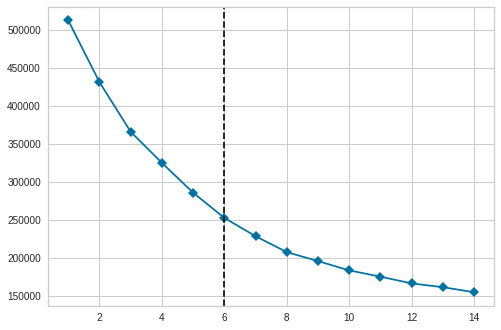

In [18]:
X=X_scaled[features]
kmeans=KMeans(random_state=1)
kmeans_vis=KElbowVisualizer(kmeans,k=(1,15),metric='distortion',timings=False).fit(X)
print('Optimal number of clusters:', kmeans_vis.elbow_value_)

In [19]:
kmean=KMeans(n_clusters=6)
kmean.fit(X)
labels=kmean.labels_

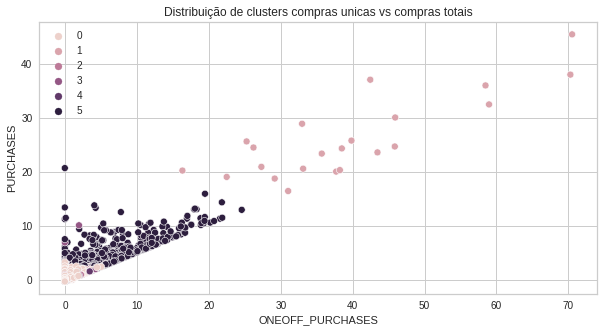

In [20]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=X,x='ONEOFF_PURCHASES',y='PURCHASES',hue=labels)
plt.title('Distribuição de clusters compras unicas vs compras totais')
plt.show()

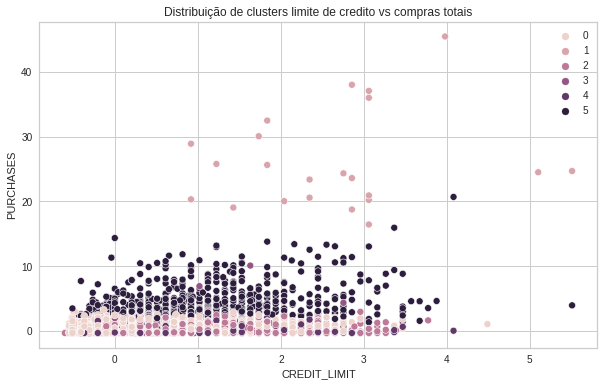

In [21]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=X, x='CREDIT_LIMIT', y='PURCHASES', hue=labels)
plt.title('Distribuição de clusters limite de credito vs compras totais')
plt.show()

In [22]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram,linkage
Z=linkage(X,method="ward")

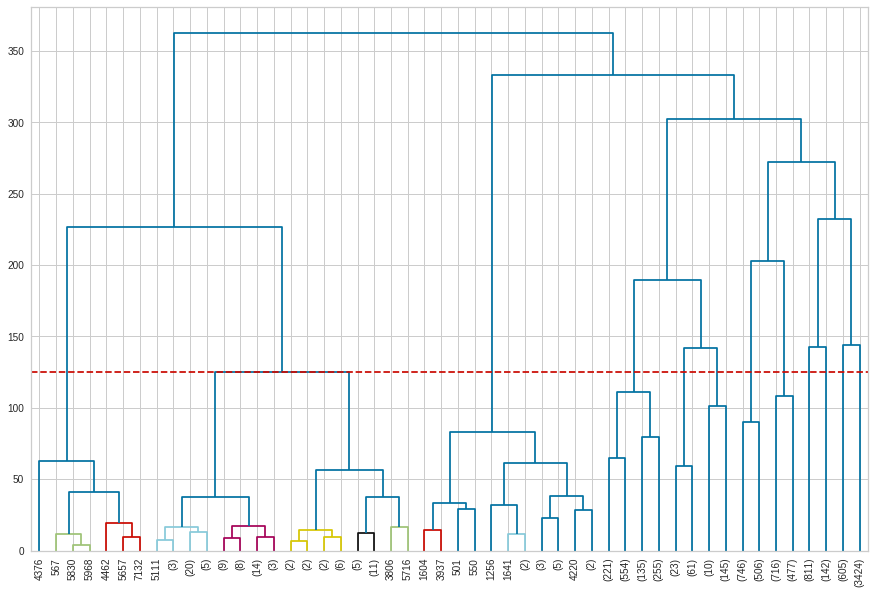

In [23]:
plt.figure(figsize=(15,10))
dendrogram(Z,leaf_rotation=90,p=5,color_threshold=20,leaf_font_size=10,truncate_mode='level')
plt.axhline(y=125, color='r', linestyle='--')
plt.show()

In [24]:
model=AgglomerativeClustering(n_clusters=6,affinity='euclidean',linkage='complete')
model.fit(X)
labelagg=model.labels_

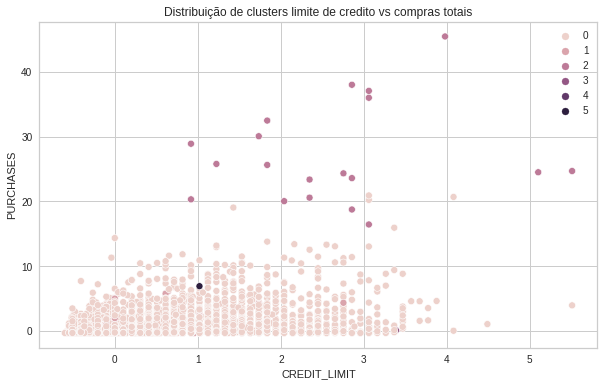

In [26]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=X, x='CREDIT_LIMIT', y='PURCHASES', hue=labelagg)
plt.title('Distribuição de clusters limite de credito vs compras totais')
plt.show()

In [27]:
from sklearn.cluster import DBSCAN
import plotly.express as px
model_db = DBSCAN(eps=11, min_samples=6, metric='euclidean')
model_db.fit(X)
X['cluster_DB'] = model_db.labels_.astype(object)+1

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(X['CREDIT_LIMIT'], X['PURCHASES'], hue=X['cluster_DB'], 
                palette=sns.color_palette('hls', np.unique(model_db.labels_).shape[0]))
plt.title('DBSCAN com epsilon 11, min amostras 6')
plt.show()

In [30]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, rand_score
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering 
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering 
from sklearn.cluster import DBSCAN

In [33]:
model = GaussianMixture(n_components=6)
y = model.fit_predict(X)

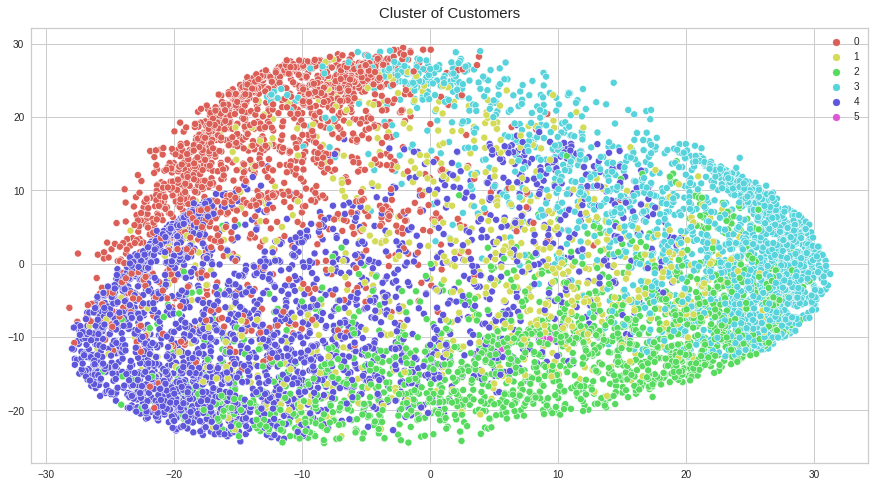

In [34]:
dist = 1-cosine_similarity(X)

pca = PCA(2)
pca.fit(dist)
X_PCA = pca.transform(dist)

# Visualizing all the clusters 
plt.figure(figsize=(15,8))
sns.scatterplot(x=X_PCA[:, 0], y=X_PCA[:, 1], 
                hue=y, palette=sns.color_palette('hls', len(np.unique(y))), s=50)
plt.title('Cluster of Customers', size=15, pad=10)
plt.legend(loc=0, bbox_to_anchor=[1,1])
plt.show()